<a href="https://colab.research.google.com/github/sandeeepmedepalli/ml-colony-classification/blob/main/YOLO_1_colonies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U ultralytics pillow matplotlib


In [ ]:
import shutil
from pathlib import Path

# remove previously downloaded zip
if Path("images.zip").exists():
    Path("images.zip").unlink()

# remove extracted images folder
if Path("images").exists():
    shutil.rmtree("images")

# remove output dataset folder too (optional)
if Path("dataset").exists():
    shutil.rmtree("dataset")

print("✅ Cleaned old images.zip, images/, dataset/")


✅ Cleaned old images.zip, images/, dataset/


In [ ]:
import gdown
from pathlib import Path

MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)

MODEL_PATH = MODEL_DIR / "best.pt"

gdown.download(
    id="1WUtXzyTxgAJ8odOT227iTPw7N4io_GQo",
    output=str(MODEL_PATH),
    quiet=False
)


Downloading...
From: https://drive.google.com/uc?id=1WUtXzyTxgAJ8odOT227iTPw7N4io_GQo
To: /content/models/best.pt
100%|██████████| 22.6M/22.6M [00:00<00:00, 179MB/s]


'models/best.pt'

In [ ]:
MODEL_PATH

PosixPath('models/best.pt')

In [ ]:
ZIP_ID = "1dv7b1JzAAZ01K8JSvfEIIGohuzxVYf5e"
ZIP_PATH = Path("images.zip")

gdown.download(
    id=ZIP_ID,
    output=str(ZIP_PATH),
    quiet=False
)

import zipfile

EXTRACT_DIR = Path("images")
EXTRACT_DIR.mkdir(exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

print("Extracted to:", EXTRACT_DIR)


Downloading...
From: https://drive.google.com/uc?id=1dv7b1JzAAZ01K8JSvfEIIGohuzxVYf5e
To: /content/images.zip
100%|██████████| 4.21M/4.21M [00:00<00:00, 52.4MB/s]

Extracted to: images


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


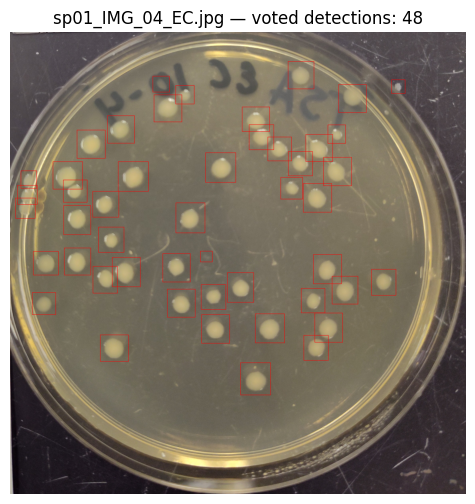

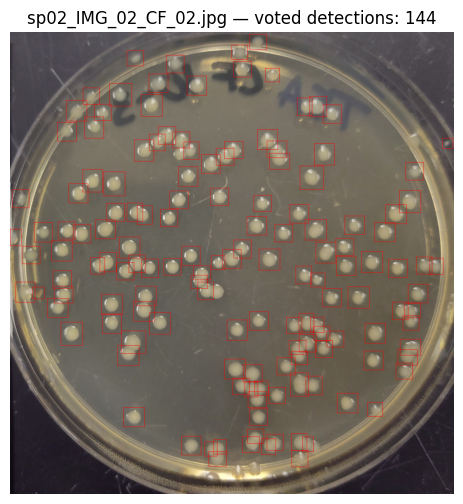

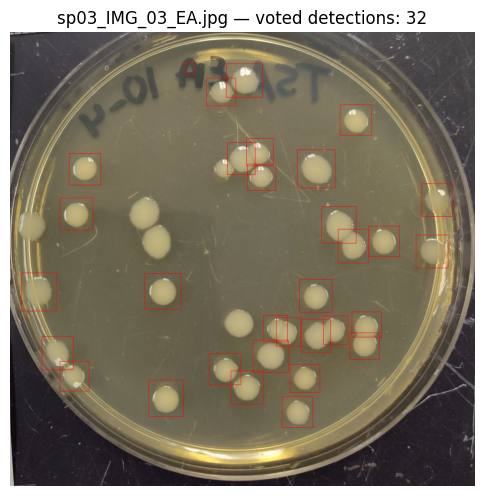

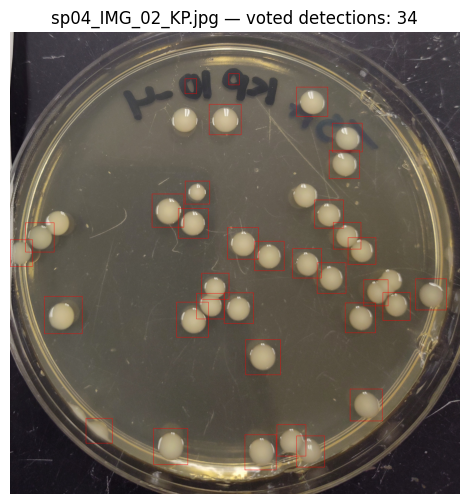

In [ ]:
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from pathlib import Path
import math
from PIL import ImageEnhance
import shutil
import re

# ---------------- CONFIG ----------------
IMG_DIR = Path("images")          # flat folder (from images.zip)
IMG_SIZE = 1024
CONF_TH = 0.05
MIN_VOTES = 4
IOU_TH = 0.75
ROT_DEG = 7

model = YOLO(MODEL_PATH)

# ---------------- NEW: DATASET STRUCTURE ----------------
DATASET_ROOT = Path("dataset")
IMG_TRAIN_DIR = DATASET_ROOT / "images" / "train"
LBL_TRAIN_DIR = DATASET_ROOT / "labels" / "train"

IMG_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
LBL_TRAIN_DIR.mkdir(parents=True, exist_ok=True)

# ---------------- WRITE data.yaml ----------------
DATA_YAML = DATASET_ROOT / "data.yaml"
if not DATA_YAML.exists():
    DATA_YAML.write_text(
        "path: .\n"
        "train: images/train\n\n"
        "names:\n"
        "  0: sp01\n"
        "  1: sp02\n"
        "  2: sp03\n"
        "  3: sp04\n"
    )

# ---------------- GEOMETRY HELPERS ----------------
def yolo_to_coco(xc, yc, w, h, iw, ih):
    bw = w * iw
    bh = h * ih
    x  = xc * iw - bw / 2
    y  = yc * ih - bh / 2
    return x, y, bw, bh

def coco_to_center(x, y, w, h):
    return x + w/2, y + h/2

def center_to_coco(cx, cy, w, h):
    return cx - w/2, cy - h/2, w, h

def coco_to_yolo_norm(x, y, w, h, iw, ih):
    xc = (x + w/2) / iw
    yc = (y + h/2) / ih
    wn = w / iw
    hn = h / ih
    return xc, yc, wn, hn

def rotate_point(cx, cy, px, py, theta):
    s, c = math.sin(theta), math.cos(theta)
    px -= cx
    py -= cy
    return px * c - py * s + cx, px * s + py * c + cy

def iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    xa = max(x1, x2)
    ya = max(y1, y2)
    xb = min(x1 + w1, x2 + w2)
    yb = min(y1 + h1, y2 + h2)
    inter = max(0, xb - xa) * max(0, yb - ya)
    union = w1*h1 + w2*h2 - inter
    return inter / union if union > 0 else 0

def vote_boxes(all_boxes):
    clusters = []
    for boxes in all_boxes:
        for b in boxes:
            placed = False
            for c in clusters:
                if iou(b[:4], c["box"][:4]) >= IOU_TH:
                    c["members"].append(b)
                    placed = True
                    break
            if not placed:
                clusters.append({"box": b, "members": [b]})

    voted = []
    for c in clusters:
        if len(c["members"]) >= MIN_VOTES:
            voted.append(max(c["members"], key=lambda x: x[4]))
    return voted

def boost_contrast(img, factor=1.4):
    return ImageEnhance.Contrast(img).enhance(factor)

def suppress_duplicates(boxes, iou_th=0.7):
    if len(boxes) == 0:
        return boxes

    boxes = np.array(boxes)
    boxes = boxes[boxes[:,4].argsort()[::-1]]
    kept = []

    while len(boxes) > 0:
        best = boxes[0]
        kept.append(best)
        boxes = np.array([b for b in boxes[1:] if iou(best[:4], b[:4]) < iou_th])

    return kept

# ---------------- MAIN LOOP ----------------
for img_path in sorted(IMG_DIR.glob("*.*")):
    img = Image.open(img_path).convert("RGB")
    iw, ih = img.size
    cx_img, cy_img = iw / 2, ih / 2

    # -------- parse class id from filename spXX_imgYY.jpg --------
    m = re.match(r"sp(\d+)_", img_path.name)
    if not m:
        raise ValueError(f"Filename does not match spXX_* pattern: {img_path.name}")
    class_id = int(m.group(1))

    all_boxes = []

    augmentations = {
        "orig": img,
        "hflip": img.transpose(Image.FLIP_LEFT_RIGHT),
        "vflip": img.transpose(Image.FLIP_TOP_BOTTOM),
        "gray": img.convert("L").convert("RGB"),
        "rot": img.rotate(ROT_DEG, resample=Image.BILINEAR),
        "contrast": boost_contrast(img),
    }

    for name, aug in augmentations.items():
        results = model.predict(
            source=aug,
            imgsz=IMG_SIZE,
            conf=CONF_TH,
            verbose=False
        )[0]

        boxes = []
        if results.boxes is not None:
            for b in results.boxes:
                xc, yc, w, h = b.xywhn[0].cpu().numpy()
                conf = float(b.conf)

                x, y, bw, bh = yolo_to_coco(xc, yc, w, h, iw, ih)
                cx, cy = coco_to_center(x, y, bw, bh)

                if name == "hflip":
                    cx = iw - cx
                elif name == "vflip":
                    cy = ih - cy
                elif name == "rot":
                    cx, cy = rotate_point(cx_img, cy_img, cx, cy, math.radians(-ROT_DEG))

                x, y, bw, bh = center_to_coco(cx, cy, bw, bh)
                boxes.append(np.array([x, y, bw, bh, conf]))

        all_boxes.append(boxes)

    voted_boxes = suppress_duplicates(vote_boxes(all_boxes), iou_th=0.6)

    # ---------------- SAVE TO YOLO DATASET ----------------
    shutil.copy(img_path, IMG_TRAIN_DIR / img_path.name)

    label_path = LBL_TRAIN_DIR / f"{img_path.stem}.txt"
    with open(label_path, "w") as f:
        for x, y, w, h, _ in voted_boxes:
            x = max(0, min(x, iw - 1))
            y = max(0, min(y, ih - 1))
            w = max(1, min(w, iw - x))
            h = max(1, min(h, ih - y))
            xc, yc, wn, hn = coco_to_yolo_norm(x, y, w, h, iw, ih)
            f.write(f"{class_id-1} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}\n")

    # ---------------- VISUALIZE ----------------
    draw = ImageDraw.Draw(img)
    for b in voted_boxes:
        x, y, w, h, conf = b
        draw.rectangle([x, y, x+w, y+h], outline="red", width=2)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"{img_path.name} — voted detections: {len(voted_boxes)}")
    plt.axis("off")
    plt.show()


In [ ]:
import shutil
from pathlib import Path

DATASET_DIR = Path("dataset")
ZIP_PATH = Path("dataset_yolo_ultralytics.zip")

# remove old zip if it exists
if ZIP_PATH.exists():
    ZIP_PATH.unlink()

shutil.make_archive(
    base_name=ZIP_PATH.with_suffix(""),
    format="zip",
    root_dir=DATASET_DIR,
)

print(f"Created {ZIP_PATH.resolve()}")


Created /content/dataset_yolo_ultralytics.zip
